## MBS simulation using time series data



In [2]:
from __future__ import division, print_function

import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from random import seed
from random import randrange


%matplotlib inline

def Vasicek_simulation(a, b, r0, sigma, n = 1000):
    rate_path = [r0]
    dt = 1 / 252
    for i in range(n):
        rand = np.random.normal()
        dr = a * (b - rate_path[-1]) * dt + sigma * np.sqrt(np.abs(dt * rate_path[-1])) * rand
        rate_path.append(rate_path[-1] + dr)
    return np.array(rate_path)

def bond_price(r, alpha, beta = 100):
    """
    This function assume the bond price follow the function form
    P = beta * exp(-alpha * r**2)
    :param alpha:
    :param beta:
    :return:
    """
    return beta * np.exp(- alpha * r ** 2)

def bond_duration(r, alpha, beta = 100):
    """
    Since the functional form of bond price is certain, then the duration is also certain
    :param r:
    :param alpha:
    :param beta:
    :return:
    """
    return 2* alpha * np.multiply(r, bond_price(r, alpha, beta)) / beta

def bond_price_real(r, alpha, noise, beta = 100):
    theory_price = bond_price(r, alpha, beta)
    price = theory_price + np.multiply(noise, np.random.normal(0,1,len(noise)))
    return price



### Exercise 1


In this case, we assume the relation between bond price and rate is exactly:

$$
P(r) = \beta e^{-\alpha * r^2}
$$

So we could calculate the duration directly from the formula.

$$
D(r) = 2 * \alpha * e^{ - \alpha * r^2}
$$

However, in reality we could only observe the price with adding noise. In our first example, we assume the noise is iid with daily volatility of about 10bps of par. This can be represent as:

$$
P_{observed}(r) = P(r) + 0.1 * Z
$$

Here Z is a normal random variable.

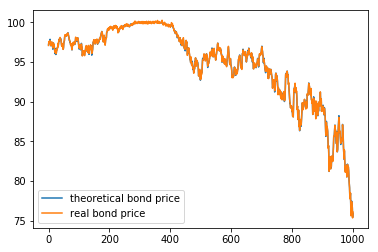

In [3]:
np.random.seed(103)
a = 0.1
b = 0.05
r0 = 0.06
sigma = 0.2
alpha = 8
noise = np.ones(1001) * 0.1
path = Vasicek_simulation(a, b, r0, sigma)
bonds = bond_price(path, alpha)
bonds_real = bond_price_real(path, alpha, noise)

plt.plot(bonds, label = "theoretical bond price")
plt.plot(bonds_real, label = 'real bond price')
plt.legend()
plt.show()

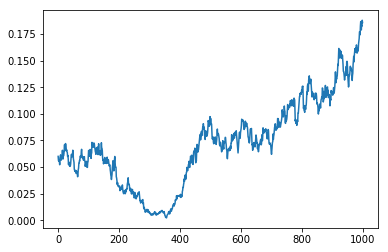

In [4]:
plt.plot(path)

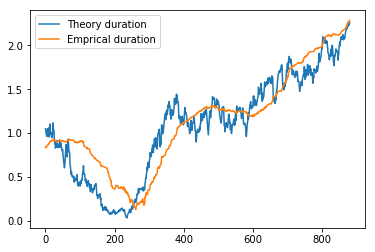

In [5]:

# Using the rolling window approximation for a duration

window = 120
return_bond = (bonds_real[1:] - bonds_real[:-1]) / bonds_real[1:]
trancate_rate = path[1:] - path[:-1]
D = []
for t in range(len(trancate_rate) - window):
    y = return_bond[t : t+window]
    x = trancate_rate[t : t+window]
    model = sm.OLS(y, x)
    result = model.fit()
    # print(result.summary())
    D.append(- result.params[0])

theory_duration = bond_duration(path, alpha)
trancated_D = theory_duration[window:]

plt.plot(trancated_D, label="Theory duration")
plt.plot(D, label = "Emprical duration")
plt.legend()
plt.show()

The durations estimated using rolling window in general is close to theory duration. However, it depends on the rate path, since for some less volatile rate path, the estimation is not good. 


## Exercise 2


Next exercise will using second order of rate to see if we could capture more information without adding more errors.



Here we assume the relation between rate and bond price is as following:

$$
P = a + br + cr^2
$$

Given the pair $(p_0,r_0)$ is the last bond price and rate in the current rolling window, we have:

$$
D_{estimated} = -\frac{b+2cr_0}{p_0}
$$

In [6]:
rate_sq = np.power(path,2)

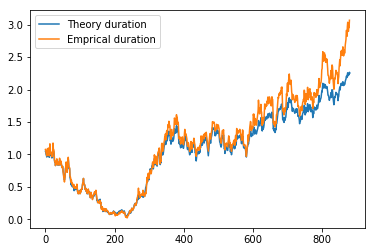

In [7]:
D_sq = []
for t in range(len(trancate_rate) - window):
    X = sm.add_constant(np.matrix([path[t:t+window], rate_sq[t:t+window]]).T)
    Y = bonds_real[t:t+window]
    last_rate = path[t+window]
    last_price = bonds_real[t+window]
    model = sm.OLS(Y, X)
    result = model.fit()
    # print(result.summary())
    D_sq.append(-(result.params[1] + 2*result.params[2]*last_rate) / last_price)
    


plt.plot(trancated_D, label="Theory duration")
plt.plot(D_sq, label = "Emprical duration")
plt.legend()
plt.show()



In [8]:
def norm_base(x):
    return (2*x-np.min(x)-np.max(x))/(np.max(x)-np.min(x)), np.max(x), np.min(x)

def orth_base(x_n,degree):
    #Creating matrix given the required degree
    Z=np.zeros((len(x_n), degree + 1))
    a=np.zeros(degree+1)
    b=np.zeros(degree)
    Z[:,0]=1
    b[0]=0
    a[0]=0
    a[1]=np.mean(x_n)
    Z[:,1]=2*(x_n-a[1])
    for i in range(2,degree+1):
        a[i]=np.sum(np.multiply(x_n,np.multiply(Z[:,i-1],Z[:,i-1])))/np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))
        b[i-1]=np.sum(np.multiply(Z[:,i-1],Z[:,i-1]))/np.sum(np.multiply(Z[:,i-2],Z[:,i-2]))
        Z[:,i]=2*(x_n-a[i]).dot(Z[:,i-1])-b[i-1]*Z[:,i-2]
    return Z.squeeze(),a,b

def fitting_OLS(reg_Y,reg_X):
    mod = sm.OLS(reg_Y, reg_X)
    res = mod.fit()
    return res.params

def regression_poly_wind(wind, X, Y, deg, delta, ploy_fit_func):
    if(len(X) != len(Y)):
        raise Exception('X and Y should have same length')
    if(len(X) < wind):
        raise Exception('Rolling window size should be larger than data size')
    
    beta = []
    pure_X = X
    pure_Y = Y
    
    for i in range((len(X)-wind)):
        reg_X = pure_X[i:i + wind]
        reg_Y = pure_Y[i:i + wind]
        x0 = reg_X[-1]
        #r0 = reg_X[-1]
        #sorted_X, sorted_Y = zip(*sorted(zip(reg_X, reg_Y)))
        beta.append(ploy_fit_func(reg_X, reg_Y, deg, x0, delta))
        #beta.append(ploy_fit_func(np.array(sorted_X), np.array(sorted_Y), deg, r0, delta))
    return beta

def normalize(x, max_x, min_x, a, b):
    
    x_norm = (2*x-max_x-min_x)/(max_x-min_x)
    x_transformed = np.array([1, 2*(x_norm -a[1]), 4*(x_norm-a[2])*(x_norm-a[1])-b[1]])
    
    return x_transformed
    

def duration_from_ortho_poly_fit_test(X, Y, deg, rate, delta):
    reg_X, a, b = orth_base(norm_base(X)[0], deg)
    max_x, min_x = norm_base(X)[1:]
    coef = np.array(fitting_OLS(Y, reg_X))
    
    rate_plus = rate + delta
    rate_minus = rate - delta
    
    price_plus = np.sum(coef * normalize(rate_plus, max_x, min_x, a, b))
    price_minus = np.sum(coef * normalize(rate_minus, max_x, min_x, a, b))
    
    return (price_plus - price_minus) / (delta * 2)

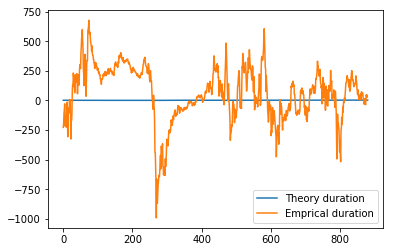

In [9]:
D_o_sq = []
for t in range(len(trancate_rate) - window):
    X = path[t:t+window]
    Y = bonds_real[t:t+window]
    last_rate = path[t+window]
    last_price = bonds_real[t+window]
    bump = duration_from_ortho_poly_fit_test(X, Y, 2, last_rate,0.01)
    D_o_sq.append(100*(-bump)/last_price)
    


plt.plot(trancated_D, label="Theory duration")
plt.plot(D_o_sq, label = "Emprical duration")
plt.legend()
plt.show()
